# <center>Test Dark Current Standard Test
# <center>Prepared by Denver Lloyd
# <center>3/03/2022

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import fivecentplots as fcp
from characterization_ams.stats_engine import pixelwise_stats as ps
from characterization_ams.stats_engine import stats
from characterization_ams.standard_tests import dark_current, ptc
from characterization_ams.utilities import image
from characterization_ams.utilities import image_generator
import pdb
import warnings
warnings.filterwarnings("ignore")

## Generate Fake DataSet

In [2]:

tint = np.linspace(0, 1, 10)
rows=100
cols=100
pedestal=168
n_images=100
images = []
temp = pd.DataFrame()
raw = pd.DataFrame()
t_c = {40:224, 50: 232, 60:260, 70:410}
idx_ = 0
for tt in t_c.keys():
    ped_start = 220
    peds = np.linspace(ped_start, t_c[tt], 10)
    for (idx, pp) in enumerate(peds):
        n_images=100
        rfpn=0.1
        cfpn=0.1
        ctn = 0.1
        rtn = 0.1
        ptn = 0.1 + np.sqrt(pp)
        #pfpn= 1 + 0.08 * (pp - ped_start)
        pfpn = 0
        tot_t = np.sqrt(ctn**2 + rtn**2 + ptn**2)
        tot_f = np.sqrt(rfpn**2 + pfpn**2 + cfpn**2)

        # fpn
        imgs = image_generator.gen_images(cfpn=cfpn,
                                          rfpn=rfpn,
                                          pfpn=pfpn,
                                          rtn=rtn,
                                          ptn=ptn,
                                          ctn=ctn,
                                          rows=rows,
                                          cols=cols,
                                          pedestal=pp,
                                          n_images=n_images)

        images.append(imgs)
        
        temp['Power'] = pd.Series(tint[idx])
        temp['imageid'] = idx_
        temp['stack size'] = n_images
        temp['rows'] = rows
        temp['cols'] = cols
        temp['Tint'] = tint[idx]
        temp['T [C]'] = tt
        idx_ += 1
        raw = pd.concat([raw, temp]).reset_index(drop=True)
    
stat_vals = ptc.get_stats(images, raw)
# create average image list for calcs    
avg_ims = []
mean = pd.DataFrame()
for ii in images:
    avg_ims.append(stats.avg_img(ii))

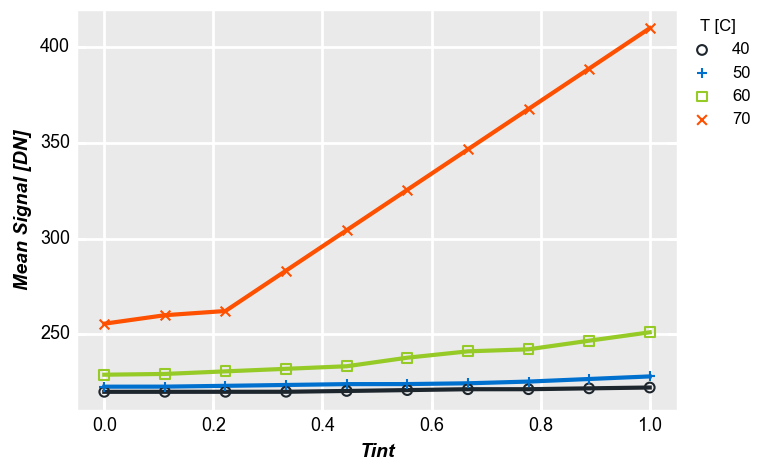

In [3]:
fcp.plot(df=stat_vals, x='Tint', y='Mean Signal [DN]', ax_size=[600,400], legend='T [C]', line_width=3)

## Standard Test

In [4]:
# get subset of data

temp = 70
test_data = stat_vals[(stat_vals['T [C]'] == temp)].reset_index(drop=True)
idx_start = test_data['imageid'].min()
idx_end = test_data['imageid'].max() + 1
ims = np.array(avg_ims[idx_start:idx_end])

In [5]:
res = dark_current.dark_current(images=ims,
                                tint=tint)

In [6]:
res.keys()

dict_keys(['dc_hist', 'dc_nq', 'summ', 'data'])

In [7]:
res['dc_hist'].columns

Index(['Value', 'Counts'], dtype='object')

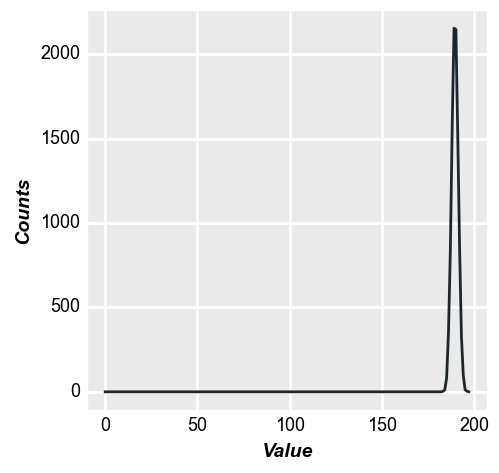

In [9]:
fcp.plot(df=res['dc_hist'], y='Counts', x='Value', markers=False, line_width=2)